In [2]:
%matplotlib inline

import numpy as n
import matplotlib.pyplot as p
import numpy.fft as f
import scipy.signal as sig
import copy

# Theory

In this notebook, I investigate the ues of optimal quadratic estimators on a simple band limited signal with a naive fourier transform and constant covariance. 

According to Ali 2015, we first estimate $\widehat{q}_\alpha$ as 
$$
\widehat{q}_\alpha = \frac{1}{2} x^\dagger C^{-1} Q_\alpha C^{-1} x - b_\alpha 
$$
where x is the data vector, $C$ is the covariance matrix, and $Q_\alpha$ performs the Fourier transform at the $\alpha^{th}$ k-bin. The power spectrum is determined from $\widehat{q}$ with the normalization matrix
$$
\widehat{p} = M \widehat{q}
$$
which results in $\widehat{p}$ being composed of an add-mixture of different modes
$$
\widehat{p} = W p
$$
where $W$ is the window function matrix with 
$$
W = MF
$$
where
$$
F_{\alpha \beta} = \frac{1}{2} tr\left[ C^{-1} Q_\alpha C^{-1} Q_\beta \right]
$$
If we do not weight $x$ by $C^{-1}$ but rather by an arbitrary weighting matrix which we will call $U$, we get a similar equation for $F$ with $C^{-1} \to U$. 
$$
F_{\alpha \beta} = \frac{1}{2} tr \left[ U Q_\alpha U Q_\beta \right]
$$
In this notebook, I will test the normalization matrix technique with $U$ set to the identity and employ te weights matrix described in Ali-2015 where $F$ is Cholsky-decomposed into $LL^\dagger$ with $L$ being lower triangular. Ali 2015 choose $M=D L^\dagger$ where $D$ is a diagonal matrix that ensures that the rows of $W=MF=DL^{-1}F$ sum to one. 


# Simple Case

We will consider a 20 frequency bins with 100 kHz widths between 149 and 151 MHz. The delay bins are 1/(2MHz) corresponding to $5 \times 10^{-7}$sec. I will set the middle two delay-bins to equal unity and zero outside. We see that the blackman window brings the side-lobes to a similar level as the signal. 

In [3]:
nf=40 #number of frequency bins
df=1e5 #width of each bin
npad=0#padding option, set to zero for now
fAxis=150e6-nf/2*df+n.arange(-nf/2,nf/2)*df #frequency axis centered at 150 MHz. 
delays=f.fftshift(f.fftfreq(nf,fAxis[1]-fAxis[0])) #delay axis


deltadelay=4 #number of delay sbins from zero (plus and minus) to contaminate with foregrounds
ndelays=2*deltadelay #number of delays (at the center of the band) to contaminate
delays2use=delays[(nf/2-deltadelay):(nf/2+deltadelay)] #delays to be contaminated by foregrounds
data=n.zeros(nf,dtype=complex) #data vector (equal to foregrounds+signal)
signal=n.zeros(nf,dtype=complex)#signal vector 
foregrounds=n.zeros(nf,dtype=complex)#foregrounds vector

scaleForegrounds=1000.
scaleSignal=30e-4

fAmps=n.random.normal(size=(ndelays,2),scale=scaleForegrounds)#each foreground mode is a complex exponential with period of delay
                                              #gaussian random amplitude and uniform random phase
sAmps=n.random.normal(size=(nf,2),scale=scaleSignal)     #signal amplitudes are gaussian in amplitude and uniform in phase. 

powerIndex=-0.8                               #modulate foreground amplitudes by power law index. 

#populate foregrounds
for mm,delay in enumerate(delays2use):
    foregrounds+=n.cos(2*n.pi*(fAxis-fAxis[nf/2])*delay)*(fAmps[mm,0])*(fAxis/fAxis[nf/2])**powerIndex
    foregrounds+=1j*n.sin(2*n.pi*(fAxis-fAxis[nf/2])*delay)*(fAmps[mm,1])*(fAxis/fAxis[nf/2])**powerIndex


#populated signal
for mm,delay in enumerate(delays):
    signal+=n.cos(2*n.pi*(fAxis-fAxis[nf/2])*delay)*(sAmps[mm,0])
    signal+=1j*n.sin(2*n.pi*(fAxis-fAxis[nf/2])*delay)*(sAmps[mm,1])

data=foregrounds+signal
#window function
window=sig.blackmanharris(nf)
window/=n.sqrt(n.mean(window**2.))
#window[:]=1.

#Apply padding, update delay axis. 
window=n.pad(window,((npad,npad)),mode='constant')
data=n.pad(data,((npad,npad)),mode='constant')
foregrounds=n.pad(foregrounds,((npad,npad)),mode='constant')
signal=n.pad(signal,((npad,npad)),mode='constant')
nf=nf+2*npad
delays=f.fftshift(f.fftfreq(nf,fAxis[1]-fAxis[0]))


#now generate a covariance matrix
#covDelay=n.diag(2.*n.ones(nf)*scaleSignal**2.)

#for mm in range(nf/2-deltadelay,nf/2+deltadelay+1):
#    covDelay[mm,mm]+=2.*scaleForegrounds**2.
    

#windowX,windowY=n.meshgrid(sig.blackmanharris(nf),sig.blackmanharris(nf))
#covFrequency=n.real(n.fliplr(f.fftshift(f.ifft2(f.fftshift(covDelay*windowX*windowY)))))
#covFrequency=n.real(n.fliplr(f.fftshift(f.ifft2(f.fftshift(covDelay)))))



fGrid,fpGrid=n.meshgrid(fAxis,fAxis)
reg=1e-4
covFrequencySignal=reg*n.identity(nf)#(scaleSignal**2.+reg)*n.identity(nf)
covFrequency=covFrequencySignal+scaleForegrounds**2.*2*n.sinc(2*(fGrid-fpGrid)*delays[nf/2+deltadelay+1])#n.sin(2*n.pi*(fGrid-fpGrid)*delays[nf/2-deltadelay])/(n.pi*(fGrid-fpGrid))
#covFrequency=n.identity(nf)
#print n.linalg.cond(covFrequency)
U,S,V=n.linalg.svd(covFrequency.conj())
covFrequencyInv=n.einsum('ij,j,jk',V.T,1./S,U.T)
covFrequencySignalInv=n.linalg.inv(covFrequencySignal)


#straightforward windowed ffts of signal, data, and foregrounds for comparison
fsignal=f.fftshift(f.fft(f.fftshift(signal*window)))
fdata=f.fftshift(f.fft(f.fftshift(data*window)))
fforegrounds=f.fftshift(f.fft(f.fftshift(foregrounds*window)))


In [4]:
print n.linalg.cond(covFrequency)

80001361298.1


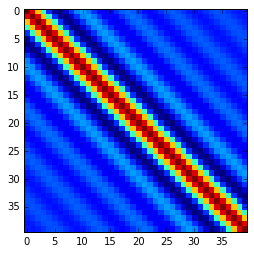

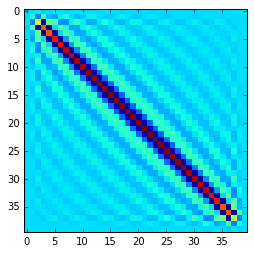

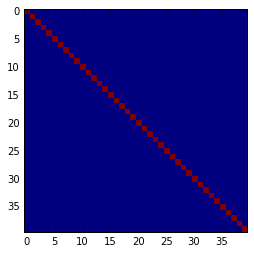

In [5]:
p.imshow((covFrequency),interpolation='nearest')
p.show()
p.imshow((covFrequencyInv),interpolation='nearest')
p.show()
p.imshow(n.dot(covFrequencyInv,covFrequency),interpolation='nearest')
p.show()

First we construct the $Q_\alpha$ matrices for each delay bin. We also compute unnormalized power spectra using the OQE formalism. We order data so that we have zero, than k0,-k1,k1,-k2,k2,-k3,k3 etc...

In [6]:
def oqe(x,wF=None,cInv=None,mode='L^-1'):
    modes=['F^-1','F^-1/2','L^-1','I']; assert(mode in modes)
    nf=len(x)
    if(cInv is None):
        cInv=n.identity(nf)
    if(wF is None):
        wF=n.ones(nf)
    qMatrices=n.zeros((nf,nf,nf),dtype=complex)
    qHat=n.zeros(nf,dtype=complex)
    pHat=n.zeros(nf,dtype=complex)
    wMat=n.zeros(nf,dtype=complex)
    mMat=n.zeros((nf,nf),dtype=complex)
    fMat=n.zeros((nf,nf),dtype=complex)
    #construct q matrices
    z=n.dot(cInv,x)
    #construct qhat
    for mm in range(nf):
        _m=n.zeros(nf)
        _m[mm]=1.
        m=f.fftshift(f.ifft(f.fftshift(_m)))*wF*nf
        qMat=n.einsum('i,j',m,m.conj())
        qMatrices[mm,:,:]=qMat
        qHat[mm]=n.dot(n.conj(z).T,n.dot(qMat,z))
    #construct fMat
    for mm in range(nf):
        for nn in range(nf):
            ftq=n.dot(cInv,n.dot(qMatrices[mm,:,:],n.dot(cInv,qMatrices[nn,:,:])))
            fMat[mm,nn]=n.trace(ftq)
        
    #construct mMat
    if(mode=='F^-1'):
        mMat=n.linalg.inv(fMat)
        wMat=n.identity(nf)
    elif(mode=='F^-1/2'):
        U,S,V=n.linalg.svd(fMat.conj())
        mMat=n.linalg.einsum('ij,j,jk',U.T,1./n.sqrt(S),V.T)
    elif(mode=='L^-1'):
        order=n.zeros(nf)
        order[0]=nf/2
        order[1]=nf/2+1
        order[2]=nf/2-1
        order[3]=nf/2+2
        order[4]=nf/2-2
        order[5]=nf-1
        order[6]=0
        for mm in range(4,nf/2):
            order[2*mm-1]=nf/2+mm-1
            order[2*mm]=nf/2-mm+1
        order[-1]=1
        order=order.astype(int)
        
        iorder = n.argsort(order)
        fMat_o = n.take(n.take(fMat,order, axis=0), order, axis=1)
        lMat_o = n.linalg.cholesky(fMat_o)
        U,S,V = n.linalg.svd(lMat_o.conj())
        mMat_o = n.dot(n.transpose(V), n.dot(n.diag(1./S), n.transpose(U)))      
        mMat = n.take(n.take(mMat_o,iorder, axis=0), iorder, axis=1)
    elif(mode=='I'):
        mMat=n.identity(nf,dtype=complex)
        
    wMat=n.dot(mMat,fMat)
    norm  = wMat.sum(axis=-1); norm.shape += (1,)
    mMat/=norm; wMat=n.dot(mMat,fMat)
    pHat=n.dot(mMat,qHat)
    return qHat,pHat,wMat,fMat


Now Compare OQE and direct fft power spectra. They are the same. This also verifies our indexing scheme.

In [7]:
qHat_data_lInv_fullCov,pHat_data_lInv_fullCov,wMat_data_lInv_fullCov,_=oqe(x=data,wF=window,cInv=covFrequencyInv,mode='L^-1')

In [8]:
qHat_data_lInv_idCov,pHat_data_lInv_idCov,wMat_data_lInv_idCov,_=oqe(x=data,wF=window,mode='L^-1')

In [9]:
qHat_data_lInv_idCov_idW,pHat_data_lInv_idCov_idW,wMat_data_lInv_idCov_idW,_=oqe(x=data,mode='L^-1')

In [10]:
qHat_data_id_idCov,pHat_data_id_idCov,wMat_data_lInv_idCov,_=oqe(x=data,wF=window,mode='I')

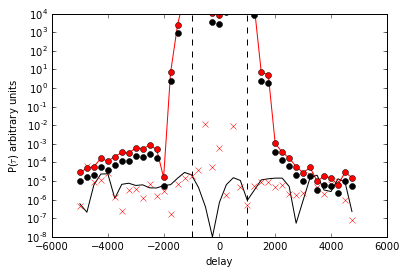

In [14]:
#plot power spectrum from windowed FT
p.plot(delays*1e9,n.abs(fdata)**2./nf/nf,color='r')
p.plot(delays*1e9,n.abs(fsignal)**2./nf/nf,color='k')
#p.plot(delays*1e9,n.abs(fforegrounds)**2.,color='grey')
#p.plot(delays*1e9,(n.abs(pHat_data_id_idCov[:])),color='r',marker='o',ls='none')

p.axvline(delays[nf/2+deltadelay]*1e9,ls='--',color='k')
p.axvline(delays[nf/2-deltadelay]*1e9,ls='--',color='k')

#plot power spectrum from OQE application
#p.plot(delays*1e9,(n.abs(qHat_data_lInv_fullCov[:])),color='k',marker='x',ls='none')
p.plot(delays*1e9,(n.abs(pHat_data_lInv_fullCov[:])),color='r',marker='x',ls='none')

p.plot(delays*1e9,(n.abs(pHat_data_id_idCov[:])),color='k',marker='o',ls='none')
p.plot(delays*1e9,(n.abs(qHat_data_id_idCov[:]))/nf/nf,color='r',marker='o',ls='none')


#p.plot(delays*1e9,(n.abs(qHat_data_lInv_idCov_idW[:])),color='k',marker='d',ls='none')
#p.plot(delays*1e9,(n.abs(pHat_data_lInv_idCov_idW[:])),color='r',marker='d',ls='none')
#p.plot(delays*1e9,(n.abs(fforegrounds_un[:])),color='grey',marker='x',ls='none')
p.yscale('log')
p.ylim(1e-8,1e4)
p.xlabel('delay')
p.ylabel('P($\\tau$) arbitrary units')


In [207]:
print qHat_data_lInv_fullCov

[  3.86265256e-03 +6.93108765e-14j   4.83834962e-03 -3.06143999e-13j
   7.99427414e-03 -7.87148124e-14j   1.34522129e-02 +9.71445147e-16j
   2.93505389e-02 -6.83342272e-14j   6.72368242e-02 -5.21804822e-14j
   1.76006493e-01 -3.35287353e-14j   5.43539625e-01 -2.69118061e-13j
   1.95976947e+00 +5.68434189e-14j   8.63260382e+00 -2.48689958e-13j
   4.28437685e+01 +1.50990331e-13j   8.12155871e+03 +2.55795385e-13j
   2.88737214e+04 +1.13686838e-13j   1.90367108e+04 +7.95807864e-13j
   3.15284256e+03 -1.13686838e-13j   1.28810197e+02 +1.24344979e-13j
   1.01782435e+00 -8.07132139e-14j   6.52797307e-04 -7.00065006e-14j
   1.65601334e-05 +6.15653362e-14j   5.12033780e-07 +9.78173705e-14j
   2.40588229e-05 +3.66197415e-14j   1.38508766e-05 +6.88338275e-14j
   1.56183692e-05 +4.43013681e-14j   1.15301973e-02 +2.81441537e-14j
   5.74810223e+00 +1.70197190e-13j   3.54173917e+02 +1.24344979e-13j
   4.39541948e+03 -1.70530257e-13j   1.27674233e+04 -4.54747351e-13j
   7.36334583e+03 -3.41060513e-13j

Now let's construct the $F$ matrix and perform Cholsky Decomposition.

In [208]:

#uMatrix=n.diag(window).astype(complex) #this is the weighting matrix 
                                       #(taking the place of the inverse covariance matrix.)
                                       #I take it to be the window function. 
fMatrix=n.zeros((nf,nf),dtype=complex)
for mm in range(nf):
    for nn in range(nf):
        ftq=n.dot(uMatrix,n.dot(qMatrixFull[mm,:,:],n.dot(uMatrix,qMatrixFull[nn,:,:])))
        fMatrix[mm,nn]=.5*n.trace(ftq)


order = n.array([10,11,9,12,8,20,0,13,7,14,6,15,5,16,4,17,3,18,2,19,1]) # XXX needs generalizing
order=n.array([10,11,9,12,8,19,0,13,7,14,6,15,5,16,4,17,3,18,2,1])
print len(order)


    
print order
iorder = n.argsort(order)
fMatrix_o = n.take(n.take(fMatrix,order, axis=0), order, axis=1)
lMatrix_o = n.linalg.cholesky(fMatrix_o)
U,S,V = n.linalg.svd(lMatrix_o.conj())
mMatrix_o = n.dot(n.transpose(V), n.dot(n.diag(1./S), n.transpose(U)))      
mMatrix = n.take(n.take(mMatrix_o,iorder, axis=0), iorder, axis=1)

wMatrix=n.dot(mMatrix,fMatrix)
norm  = wMatrix.sum(axis=-1); norm.shape += (1,)
mMatrix/=norm; wMatrix=n.dot(mMatrix,fMatrix)



#mMatrix=n.linalg.inv(fMatrix)

fdata_n=n.dot(mMatrix,fdata_un)
fsignal_n=n.dot(mMatrix,fsignal_un)
fforegrounds_n=n.dot(mMatrix,fforegrounds_un)



NameError: name 'uMatrix' is not defined

In [209]:
print mMatrix.shape
print fforegrounds_un.shape

NameError: name 'mMatrix' is not defined

In [210]:
p.imshow(n.log10(n.abs(n.dot(mMatrix,fMatrix))),interpolation='nearest',vmin=-18,vmax=0)
p.colorbar()
p.show()

NameError: name 'mMatrix' is not defined

Compare the normalized power spectrum $\widehat{p} = M \widehat{q}$. Things definitely don't look better...

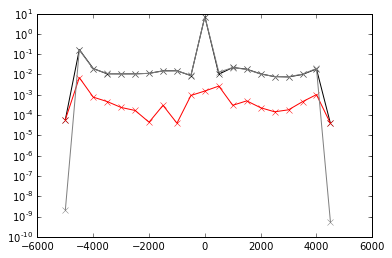

In [217]:
#p.plot(delays*1e9,n.abs(fdata_un[:]),color='k',marker='o',ls='none')
#p.plot(delays*1e9,n.abs(fsignal_un[:]),color='r',marker='o',ls='none')
#p.plot(delays*1e9,n.abs(fforegrounds_un[:]),color='grey',marker='o',ls='none')

p.plot(delays*1e9,(n.abs(fdata_n[:])),color='k',marker='x')#,ls='none')
p.plot(delays*1e9,(n.abs(fsignal_n[:])),color='r',marker='x')#,ls='none')
p.plot(delays*1e9,(n.abs(fforegrounds_n[:])),color='grey',marker='x')#,ls='none')
p.yscale('log')


Lets check on the window function which is equal to $W=MF=DL^\dagger$ and compare to the unnormalized window function. We see that the unnormalized window function is a blackman harris window while the normalized one is a blackman with the lower k values excised. This seems sensible and I'm surprised that we are seeing as much foreground leakage as we are. 

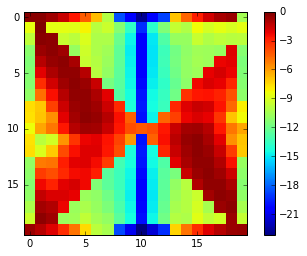

In [218]:
p.imshow(n.log10(n.abs(wMatrix)),interpolation='nearest')
p.colorbar()
p.show()